In [134]:
import minari
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch import nn, Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import statistics as stat
import os
from tqdm import tqdm

In [130]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [114]:
dataset = minari.load_dataset('D4RL/pointmaze/umaze-v2')

for episode_data in dataset.iterate_episodes():
    observations = episode_data.observations
    actions = episode_data.actions
    rewards = episode_data.rewards
    terminations = episode_data.terminations
    truncations = episode_data.truncations
    infos = episode_data.infos
obs_tensor = observations["observation"]

print(obs_tensor.shape)
print(actions.shape)
print(terminations.shape)

(34, 4)
(33, 2)
(33,)


In [115]:
obs_tensor = torch.from_numpy(obs_tensor).to(device)
# If used later in the code, might cause problems here with already being a tensor. Add IF statement if problem reoccurs.

action_tensor = torch.from_numpy(actions).to(device)
reward_tensor = torch.from_numpy(rewards).to(device)
terminations_tensor = torch.from_numpy(terminations).to(device)
truncations_tensor = torch.from_numpy(truncations).to(device)

N_min = min(len(obs_tensor), len(action_tensor), len(reward_tensor), len(terminations_tensor), len(truncations_tensor))

obs_tensor = obs_tensor[:N_min]  # Trim to 33
action_tensor = action_tensor[:N_min]
reward_tensor = reward_tensor[:N_min]
terminations_tensor = terminations_tensor[:N_min]
truncations_tensor = truncations_tensor[:N_min]

print(f"obs tensor shape: {obs_tensor.shape}")
print(f"action shape: {actions.shape}")
print(f"terminations shape:{terminations.shape}")

class TrajectoryDataset(Dataset):
    def __init__(self, observations, actions, rewards, terminations, truncations):
        self.observations = observations
        self.actions = actions
        self.rewards = rewards
        self.terminations = terminations
        self.truncations = truncations

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx], self.rewards[idx], self.terminations[idx], self.truncations[idx]

dataset = TrajectoryDataset(obs_tensor, action_tensor, reward_tensor, terminations_tensor, truncations_tensor)


obs tensor shape: torch.Size([33, 4])
action shape: (33, 2)
terminations shape:(33,)


In [116]:
print(f"Observations shape: {obs_tensor.shape}")
print(f"Actions shape: {action_tensor.shape}")
print(f"Rewards shape: {reward_tensor.shape}")
print(f"Terminations shape: {terminations_tensor.shape}")
print(f"Truncations shape: {truncations_tensor.shape}")

dataset = TrajectoryDataset(obs_tensor, action_tensor, reward_tensor, terminations_tensor, truncations_tensor)
print("Length of dataset: ", len(dataset))

Observations shape: torch.Size([33, 4])
Actions shape: torch.Size([33, 2])
Rewards shape: torch.Size([33])
Terminations shape: torch.Size([33])
Truncations shape: torch.Size([33])
Length of dataset:  33


In [117]:
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [118]:
def flow_matching_loss(model, x_start, x_end, timesteps):
    """
    Computes the flow matching loss.

    Args:
        model (nn.Module): The trajectory flow model
        x_start (Tensor): Initial observations (N, T, D_obs)
        x_end (Tensor): Target observations (N, T, D_obs)
        timesteps (Tensor): Random time values (N, T, 1)
    
    Returns:
        Tensor: Scalar loss value
    """
    # Generate noisy interpolation between start and end
    alpha = timesteps  # Time-dependent interpolation coefficient
    x_t = alpha * x_start + (1 - alpha) * x_end  # Interpolated trajectory
    x_t = x_t.to(device, dtype=torch.float32)
    
    timesteps = timesteps.to(device)

    velocity_pred = model(x_t, timesteps)
    velocity_target = x_end - x_start
    
    loss = F.mse_loss(velocity_pred, velocity_target)
    loss = loss.to(device, dtype=torch.float32)
    
    return loss

In [119]:
class TrajectoryFlowModel(nn.Module):
    def __init__(self, obs_dim, hidden_dim=128, num_layers=3):
        """
        A neural network that estimates the velocity field for flow matching.
        
        Args:
            obs_dim (int): Dimensionality of observations (D_obs)
            hidden_dim (int): Number of hidden units in the MLP
            num_layers (int): Number of layers in the MLP
        """
        super().__init__()
        
        layers = []
        input_dim = obs_dim + 1  # We include time `t` as an input
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim  # Keep hidden layer size consistent
        
        layers.append(nn.Linear(hidden_dim, obs_dim))  # Output has the same shape as observations
        self.network = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        Forward pass for the trajectory flow model.
        
        Args:
            x (Tensor): Input observations of shape (N, T, D_obs)
            t (Tensor): Time conditioning of shape (N, T, 1)
        
        Returns:
            Tensor: Predicted velocity field of shape (N, T, D_obs)
        """
        # Concatenate time `t` to observations
        xt = torch.cat([x, t], dim=-1)
        velocity = self.network(xt)  # Predict flow field
        return velocity  # Shape: (N, T, D_obs)

In [135]:
epochs = 5000
lr = 1e-3
T = 32
D_Obs = 4  # Magic number here, equal to the batch_trajs.shape found in the for loop
dt = 0.1  # Small timestep increment
model = TrajectoryFlowModel(D_Obs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []

for epoch in tqdm(range(epochs), desc="Training Progress"):
    for batch in train_loader:
        batch_trajs = batch[0]
        
        batch_size = batch_trajs.shape[0]  # Should be 32 i.e. the batch_size defined earlier in the code.

        # Takes all rows and first two/last two columns respectively, adds a dimension at index 1, and expands it to match the size of T (which pretty much is the batch_size)
        positions = batch_trajs[:, :2].unsqueeze(1).expand(batch_size, T, 2)
        velocities = batch_trajs[:, 2:].unsqueeze(1).expand(batch_size, T, 2)  # [32, 32, 2]

        # Creates a time grid with shape [32], adds a dimension at index 0, to later combine with the trajectories to create a time dimension
        time_grid = torch.arange(T, dtype=torch.float32, device=device).unsqueeze(0).expand(batch_size, T) * dt  # [32, 32, 1]

        traj_positions = positions + velocities * time_grid.unsqueeze(-1)  # Combines initial positions with the velocities

        synth_trajs = torch.cat([traj_positions, velocities], dim=-1).to(device)  # Concatenates along the last dimension
        
        N, T, D_Obs = synth_trajs.shape
        
        split_point = T // 2
        x_start = synth_trajs[:, :split_point, :].to(device, dtype=torch.float32)  # [32, 16, 4]
        x_end = synth_trajs[:, split_point:, :].to(device, dtype=torch.float32)  # [32, 16, 4]
        
        # Generate random timesteps for this batch
        timesteps = torch.rand(batch_size, split_point, 1, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        loss = flow_matching_loss(model, x_start, x_end, timesteps)
        loss = loss.to(device, dtype=torch.float32)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

Training Progress: 100%|██████████| 5000/5000 [00:35<00:00, 142.01it/s]


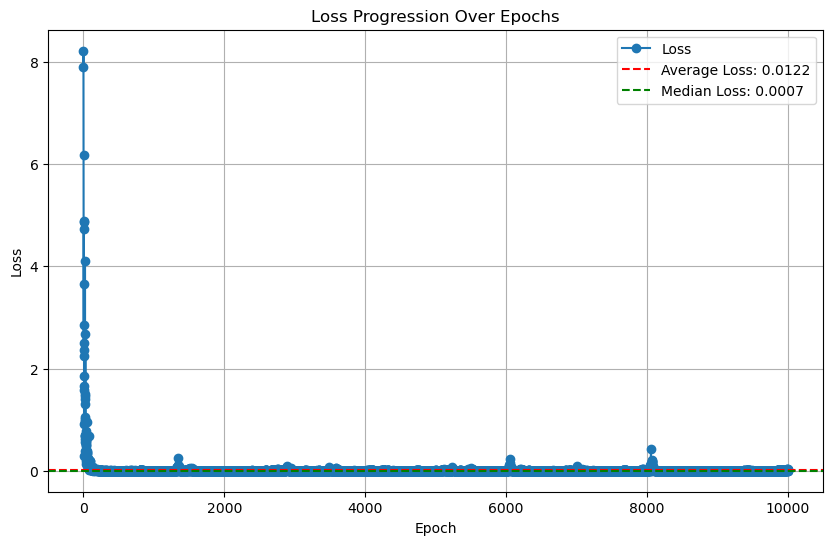

In [136]:
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

save_dir = 'Plotted loss'
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, 'loss_plot.png')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss', marker='o')
plt.axhline(y=avg_loss, color='r', linestyle='--', label=f'Average Loss: {avg_loss:.4f}')
plt.axhline(y=med_loss, color='g', linestyle='--', label=f'Median Loss: {med_loss:.4f}')
plt.title('Loss Progression Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()

## Sampling

* Implement ODE solver
* Generate noisy trajectories
* Display
* Store